# Setup pre-processing libraries

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pickle

# Setting the path where we will get the images

### In this case Img/Train and Img/Test.

### With the variable image_count we know the total number of images with extension .jpg that we have.

### Note: all images were saved in .jpg.

In [6]:
train_data_dir= "Img/Train"
test_data_dir= "Img/Test"
train_data_dir = pathlib.Path(train_data_dir)
test_data_dir = pathlib.Path(test_data_dir)
train_image_count = len(list(train_data_dir.glob('*/*.jpg')))
test_image_count = len(list(test_data_dir.glob('*/*.jpg')))
print(train_image_count)
print(test_image_count)

86
76


# Obtenemos las etiquetas de las imagenes.

### In this section we create an array where save the general labels into CLASS_NAMES variable

In [7]:
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['AFace', 'NFace'], dtype='<U5')

# Check the files

### In this part we check if we have imported the images correctly and the program has access to them, we will show 2 images randomly to check that we are accessing correctly.

Normal face


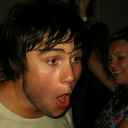

Anaphylaxis face


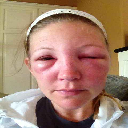

In [9]:
import random
faces1 = list(train_data_dir.glob('NFace/*'))
faces2 = list(train_data_dir.glob('AFace/*'))

print("Normal face")

n1 = random.randint(1,len(faces1)-2)
n2 = random.randint(1,len(faces2)-2)

for image_path in faces1[n1:n1+1]:
    display.display(Image.open(str(image_path)))
    
print("Anaphylaxis face")
    
for image_path in faces2[n2:n2+1]:
    img=Image.open(str(image_path))
    newsize = (128, 128) 
    img = img.resize(newsize) 
    display.display(img)

# Creating the image generator

### Because our database of people with a face having an anaphylactic reaction is very small, we will use the TensorFlow preprocessing libraries to obtain as many images as possible within our batch, the generated images will have the following changes.

- Rescale : Normalize the input data
- Zoom_range : Randomly zooms the image in and either adds new pixel values around the image or interpolates pixel values respectively.
<img src="Jimg/1.JPG">
- Rotation_range : Randomly rotates the image clockwise or anti-clockwise by a given number of degrees.
<img src="Jimg/2.JPG">
- Width_shift_range and Height_shift_range: A shift to an image means moving all pixels of the image in one direction, such as horizontally or vertically, while keeping the image dimensions the same.
<img src="Jimg/3.JPG">
- Horizontal_flip : An image flip means reversing the columns of pixels.
<img src="Jimg/4.JPG">



In [10]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1. / 255,
    zoom_range=0.2,
    rotation_range = 15,
    
    # Optional
    
#   width_shift_range=.15, 
#   height_shift_range=.15,
    horizontal_flip=True)


# We create the input image flows for the model.

### The input flow generate batches of tensor image data with real-time data augmentation for our model.

### In this section we declare the parameters for training and for the input of the model.

- BATCH_SIZE : Defines the number of samples that will be propagated through the network.
- IMG_HEIGHT = Image height in the generator and the tensor 
- IMG_WIDTH = Image width in the generator and the tensor 
- EPOCH = Training cycles.
- STEPS_PER_EPOCH : Total number of steps (batches of samples) to yield from generator.

In [11]:
BATCH_SIZE = 10
IMG_HEIGHT = 128
IMG_WIDTH = 128
EPOCH = 50
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

pickle_out = open("Vars/img.pickle","wb")
pickle.dump(IMG_HEIGHT, pickle_out)
pickle_out.close()

train_data_gen = image_generator.flow_from_directory(
    directory=str(train_data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes = list(CLASS_NAMES))

test_data_gen = image_generator.flow_from_directory(  
    directory=str(test_data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes = list(CLASS_NAMES))

Found 86 images belonging to 2 classes.
Found 76 images belonging to 2 classes.


# Sampling of the generator to observe what input data the model will have during training.

### In this section we generate 5 images from the generator and we will plot them to observe how the generator works.

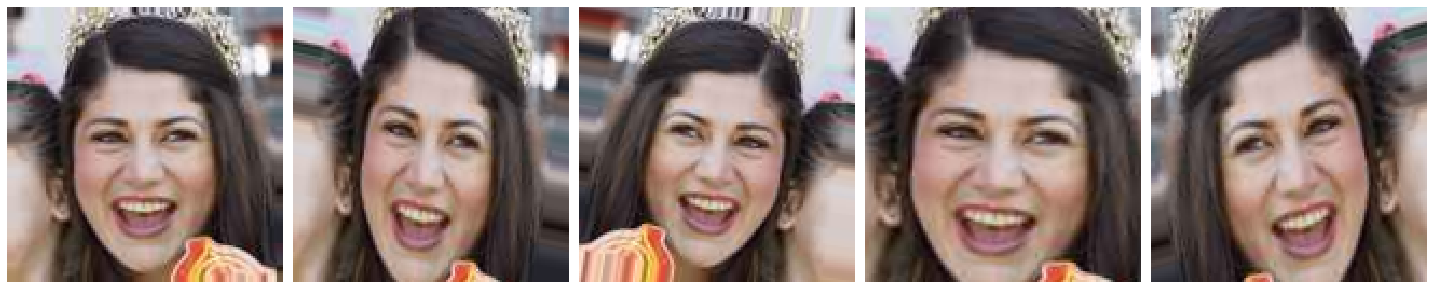

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(augmented_images)

# General display of the input data with labels. 

### This step is important to check that the data is ready to start the training.

10


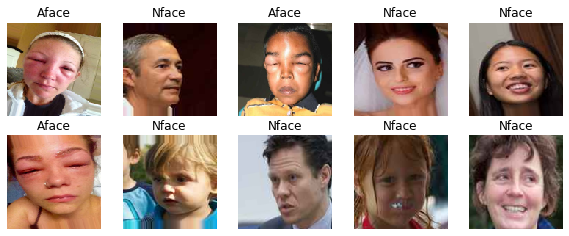

In [21]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)
print(len(image_batch))

# Preparation of the model for training.

### Nuestro modelo tiene la siguiente estructura:

<img src="Jimg/conv.png">

### This structure gave us the best results in the Jetson Nano and has more official TensorFlow documentation.

Convolutional Layer: layer that through filters obtains the characteristics of each image so that the neural network can be trained.

Maxpooling Layer:layer that through the pooling obtains the most representative characteristics of each characteristic of the convolutional layer.

Flatten Layer: layer that converts all data obtained from past layers into a one-dimensional matrix.

Dense Layer: regular densely-connected NN layer.

- 1st Conv2D Layer: 
    - Filter: 32
    - Kernel size: (3,3)
    - Input Shape : (128,128,3) -> (IMG_HEIGHT,IMG_WIDTH,RGB)
    - Activation : Relu
- 1st MaxPooling2D Layer:
    - Pool Size: (2,2)
- 2nd Conv2D Layer: 
    - Filter: 64
    - Kernel size: (3,3)
    - Activation : Relu
- 2nd MaxPooling2D Layer:
    - Pool Size: (2,2)
- Flatten Layer:
    - No special parameters
- 1st Dense Layer:
    - Number of neurons : 128
- 2nd Dense Layer (Output layer):
    - Number of neurons : 2
    - Activation : sigmoid

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from fan import fan_speed
import pickle

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(128))

model.add(Dense(2))
model.add(Activation('sigmoid'))

# Model compiling

### For the compilation of the model the following parameters were selected

- For the loss function, binary_crossentropy was selected because it is the best for models that only have binary decision making.
    - loss : binary_crossentropy
    
- For optimizer i select Adam: is a popular algorithm in the field of deep learning because it achieves good results fast.
    - optimizer : adam
    <img src="Jimg/adam.png">
    
- Since we want to visualize how the network improves as it trains, we will generate the 'accuracy' metric
    - Metrics : accuracy

### The EarlyStopping and ReduceLROnPlateau function are callback functions that will monitor the network to avoid over-fitting once they are no longer improves during training, they are responsible for stopping training when their parameters occur, in addition to, a board like the JetsonNano, making models for a long time can generate a strong work load that can damage it over time.

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
callbacks_list = [early_stop, reduce_lr]  

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

# Model Training

### En esta seccion entrenaremos el modelo con todos los parametros que se comentaron en los puntos anteriores.

- Image generators will be used to train each epoch
- Callback functions will stop the train in case the model does not improve any more between epoch
- Since my jetson has a fan, the fan_speed function makes the fan go to full power during training.

### After training we save through the pickle library all the values and variables necessary for the webapp.

In [16]:
fan_speed(250)

model_history = model.fit_generator(  
    train_data_gen,
    epochs=EPOCH,
    steps_per_epoch=train_image_count // BATCH_SIZE,
    validation_data=test_data_gen,
    validation_steps=test_image_count // BATCH_SIZE,
    callbacks=callbacks_list)

fan_speed(120)
# Plot training & validation accuracy values
model.save('Av2.models')

# Save Vars

pickle_out = open("Vars/acc.pickle","wb")
pickle.dump(model_history.history['accuracy'], pickle_out)
pickle_out.close()
pickle_out = open("Vars/loss.pickle","wb")
pickle.dump(model_history.history['loss'], pickle_out)
pickle_out.close()
pickle_out = open("Vars/accr.pickle","wb")
pickle.dump(model_history.history['val_accuracy'], pickle_out)
pickle_out.close()
pickle_out = open("Vars/lossr.pickle","wb")
pickle.dump(model_history.history['val_loss'], pickle_out)
pickle_out.close()
pickle_out = open("Vars/imge.pickle","wb")
pickle.dump(image_count, pickle_out)
pickle_out.close()
pickle_out = open("Vars/epp.pickle","wb")
pickle.dump(len(model_history.history['accuracy']), pickle_out)
pickle_out.close()

255
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 7 steps
Epoch 1/50
8/8 [==============================] - 1s 187ms/step - loss: 3.6567 - accuracy: 0.5461 - val_loss: 0.8400 - val_accuracy: 0.5643
Epoch 2/50
8/8 [==============================] - 1s 147ms/step - loss: 0.6105 - accuracy: 0.7039 - val_loss: 0.6451 - val_accuracy: 0.6143
Epoch 3/50
8/8 [==============================] - 1s 176ms/step - loss: 0.5583 - accuracy: 0.6842 - val_loss: 0.6155 - val_accuracy: 0.6714
Epoch 4/50
8/8 [==============================] - 1s 162ms/step - loss: 0.4784 - accuracy: 0.7895 - val_loss: 0.5140 - val_accuracy: 0.7714
Epoch 5/50
8/8 [==============================] - 1s 151ms/step - loss: 0.4459 - accuracy: 0.8158 - val_loss: 0.8580 - val_accuracy: 0.5929
Epoch 6/50
8/8 [==============================] - 1s 148ms/step - loss: 0.3851 - accuracy: 0.8158 - val_loss: 0.5422 - val_accurac

# With the training done, we graph the results

### In most DL models, such as these are the two graphs that most represent the model information, the acurancy graph and the loss graph.

- Loss value implies how well or poorly a certain model behaves after each iteration of optimization.
- The accuracy is used to measure the algorithm’s performance.

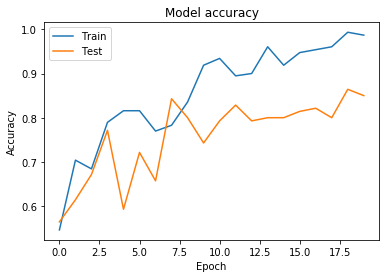

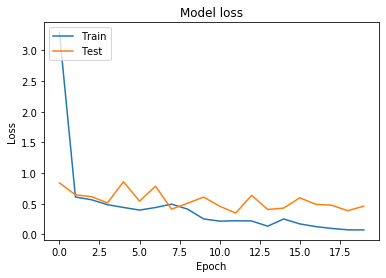

In [18]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

pickle_in = open("Vars/epp.pickle","rb")
epp= pickle.load(pickle_in)
pickle_in = open("Vars/acc.pickle","rb")
acce = pickle.load(pickle_in)
pickle_in = open("Vars/loss.pickle","rb")
losse= pickle.load(pickle_in)
pickle_in = open("Vars/accr.pickle","rb")
accer = pickle.load(pickle_in)
pickle_in = open("Vars/lossr.pickle","rb")
losser= pickle.load(pickle_in)
pickle_in = open("Vars/imge.pickle","rb")
image = pickle.load(pickle_in)
pickle_in = open("Vars/img.pickle","rb")
IMG_HEIGHT = pickle.load(pickle_in)
IMG_WIDTH = IMG_HEIGHT

plt.plot(acce)
plt.plot(accer)

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(losse)
plt.plot(losser)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Random model review with any of the test data

### In this test we will compare the model predicted value and the real value of the image, this we can show if the model is doing its job well.

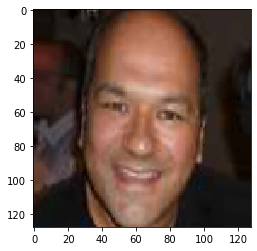

Model Values: AFace 1.7388565465807915 % and NFace 98.88831973075867 %
Model Result: NFace
Real  Result: NFace


In [38]:
from tensorflow.keras.models import load_model

pickle_in = open("Vars/img.pickle","rb")
IMG_HEIGHT = pickle.load(pickle_in)
IMG_WIDTH = IMG_HEIGHT

test_image_batch, test_label_batch = next(test_data_gen)

model = load_model("Av2.models")
CATEGORIES = ["AFace","NFace"]

n=random.randint(1,len(test_image_batch)-1)
prediction3 = model.predict(test_image_batch[n].reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3))
plt.imshow(test_image_batch[n])  # graph it
plt.show()  # display!
print("Model Values: " + str(CATEGORIES[0])+" " + str(prediction3[0][0]*100)+" %"+ " and "+str(CATEGORIES[1])+" " + str(prediction3[0][1]*100)+" %")
print("Model Result: " + str(CATEGORIES[np.argmax(prediction3[0])]))
print("Real  Result: "+ str(CATEGORIES[int(test_label_batch[n][1])]))

# Function test of the camera and the model.

### In this section we will check that the Jetson can take a picture through the camera and process it by the model, so we can make a prediction.

Algorithm:

- The Jetson takes a picture with the camera.
- The image taken is saved as a file.
- The file is opened and processed in such a way that the model can read it as a valid input.
- The model gives us a prediction.

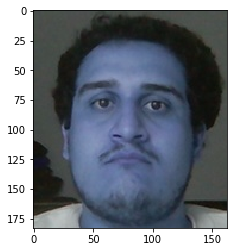

NFace
[0.27082992 0.6624618 ]


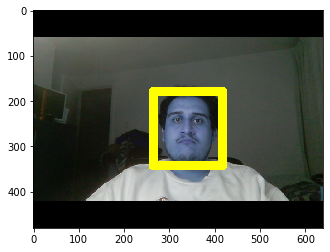

In [40]:
import cv2 
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
%matplotlib inline

CATEGORIES = ["AFace","NFace"]
pickle_in = open("Vars/img.pickle","rb")
IMG_HEIGHT = pickle.load(pickle_in)
IMG_WIDTH = IMG_HEIGHT

def prepare(filepath):
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, (IMG_HEIGHT, IMG_WIDTH))
    new_array = new_array.astype('float32')/255
    return new_array.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)

model = load_model("Av2.models")

face_cascade = cv2.CascadeClassifier('Haar/haarcascade_frontalface_default.xml') 
capture = cv2.VideoCapture(0) 

reg, webcamFrame = capture.read() 
grayImage = cv2.cvtColor(webcamFrame, cv2.COLOR_BGR2GRAY) 

faces = face_cascade.detectMultiScale(grayImage, 1.3, 5) 

for (x,y,w,h) in faces: 
    crop_img = webcamFrame[y-25:y+h+25, x-15:x+w+15]
    cv2.imwrite("input.jpg", crop_img) 
    cv2.rectangle(webcamFrame,(x-10,y-10),(x+w+10,y+h+20),(255,255,0),20) 
    roi_gray = grayImage[y:y+h, x:x+w] 
    roi_color = webcamFrame[y:y+h, x:x+w]
    prediction = model.predict([prepare('input.jpg')])
    img_array = cv2.imread('input.jpg')  # convert to array
    plt.imshow(img_array)  # graph it
    plt.show()  # display!
    print(CATEGORIES[np.argmax(prediction[0])]) 
    print(prediction[0])
    plt.imshow(webcamFrame)

capture.release()
cv2.destroyAllWindows()

# DEMO

### This demo has the following features.

- Allow communication with our webapp through AWS IoT
- Respond to website requests for data on the model, such as:
    - Epoch
    - Image number
    - Accuracy
    - Loss
- Send notifications in real time if the patient is having an anaphylactic reaction or not.

The description of each part of the code will be commented.

In [ ]:
import paho.mqtt.client as paho
import time
import ssl
import cv2 
import boto3
from tensorflow.keras.models import load_model
import pickle

# Loading all model variables for the webapp from pickle

pickle_in = open("Vars/epp.pickle","rb")
epp= pickle.load(pickle_in)
pickle_in = open("Vars/acc.pickle","rb")
acce = pickle.load(pickle_in)
pickle_in = open("Vars/loss.pickle","rb")
losse= pickle.load(pickle_in)
pickle_in = open("Vars/accr.pickle","rb")
accer = pickle.load(pickle_in)
pickle_in = open("Vars/lossr.pickle","rb")
losser= pickle.load(pickle_in)
pickle_in = open("Vars/imge.pickle","rb")
image = pickle.load(pickle_in)
pickle_in = open("Vars/img.pickle","rb")
IMG_HEIGHT = pickle.load(pickle_in)
IMG_WIDTH = IMG_WIDTH

# We are communicating with the webapp through JSON, so we have to convert all the data of our model into a JSON that the website can interpret as valid data

# This array sends the model epoch to be able to graph them.
chl = [0,round(epp*0.1),round(epp*0.2),round(epp*0.3),round(epp*0.4),round(epp*0.5),round(epp*0.6),round(epp*0.7),round(epp*0.8),round(epp*0.9),epp]

# This array sends the accuracy values of the model to be able to graph them.
ch1d = [0,acce[round(epp*0.1)],acce[round(epp*0.2)],acce[round(epp*0.3)],acce[round(epp*0.4)],acce[round(epp*0.5)],acce[round(epp*0.6)],acce[round(epp*0.7)],acce[round(epp*0.8)],acce[round(epp*0.9)],acce[epp-1]]

# This provision sends the loss values of the model to be able to graph them.
ch2d = [losse[0],losse[round(epp*0.1)],losse[round(epp*0.2)],losse[round(epp*0.3)],losse[round(epp*0.4)],losse[round(epp*0.5)],losse[round(epp*0.6)],losse[round(epp*0.7)],losse[round(epp*0.8)],losse[round(epp*0.9)],losse[epp-1]]

# This is the JSON that we are going to send to the webapp.
send = (   
       ' {'
       ' "images":'+str(image)+','
       ' "epochs":'+str(epp)+','
       ' "acc":'+str(round(acce[epp-1]*100,6))+','
       ' "loss":'+str(round(losse[epp-1],6))+','
       ' "chl":'+str(chl)+','
       ' "ch1d":'+str(ch1d)+','
       ' "ch2d":'+str(ch2d)+''
       '}'
        )
        
    
#Loading the Model
model = load_model("Av2.models")

# Setup the S3 client to be able to send the image of the patient's face when the model detect anaphylaxis
s3_client = boto3.client('s3')

EndPoint = "YOURENDPOINT.us-east-1.amazonaws.com"
BuketName = "yourbucketname"
caPath = "Certs/aws-iot-rootCA.crt"
certPath = "Certs/ThingCert.cert.pem"
keyPath = "Certs/PrivateCert.private.key"


# Setup the callback functions

# This function trigger if the client connected
def on_connect(client, userdata, flags, rc):
    print("Connection returned result: " + str(rc) )
    #client.subscribe("#" , 1 ) # Wild Card

# This function trigger every time we receive a message from the platform
def on_message(client, userdata, msg):
    if(msg.topic=='/ChartsInfoS'):
        mqttc.publish('/ChartsInfoR', send)
    print("topic: "+msg.topic)
    print("payload: "+str(msg.payload))
    
# This function trigger when we publish  
def on_publish(client, obj, mid):
    print("mid: " + str(mid))
    
# This function trigger when we subscribe to a new topic  
def on_subscribe(client, obj, mid, granted_qos):
    print("Subscribed: " + str(mid) + " " + str(granted_qos))
    
# This function prepares the file read by the camera to be reviewed by the model
def prepare(filepath):
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, (IMG_HEIGHT, IMG_WIDTH))
    new_array = new_array.astype('float32')/255
    return new_array.reshape(-1,IMG_HEIGHT, IMG_WIDTH, 3)


# We prepare all callback functions and credentials.
mqttc = paho.Client()
mqttc.on_connect = on_connect
mqttc.on_message = on_message
mqttc.on_publish = on_publish
mqttc.on_subscribe = on_subscribe
mqttc.tls_set(caPath, certfile=certPath, keyfile=keyPath, cert_reqs=ssl.CERT_REQUIRED, tls_version=ssl.PROTOCOL_TLSv1_2, ciphers=None)
mqttc.connect(EndPoint, 8883, keepalive=60)
rc = 0

# We subscribe to the topic we use to communicate from the Webapp to the Jetson
mqttc.subscribe('/ChartsInfoS')

# This variable is responsible for counting the number of cycles to take a photo every 30 seconds.
tick = 0

while rc == 0:
    rc = mqttc.loop()
    if(tick == 30):
        tick=0
        # To detect if the camera has a face in front of us, we use a very common technique called haarcascade
        face_cascade = cv2.CascadeClassifier('Haar/haarcascade_frontalface_default.xml') 
        # We took the photo of the camera connected to the Jetson Nano
        capture = cv2.VideoCapture (0)
        reg, webcamFrame = capture.read ()
        # We convert the image to grayscale for haarcascade analysis
        grayImage = cv2.cvtColor (webcamFrame, cv2.COLOR_BGR2GRAY)
        # We apply the haarcascade to indicate the position of the faces detected
        faces = face_cascade.detectMultiScale (grayImage, 1.3, 5)
        # If haarcascade detected a face, we will check if the face is normal or suffers an anaphylaxis reaction.
        for (x,y,w,h) in faces:
            # From the image taken with the camera, which we not convert into grayscale, we cut the image of the face
            crop_img = webcamFrame [y-50: y + h + 100, x-30: x + w + 30]
            # Save the image as a file
            cv2.imwrite ("input.jpg", crop_img)
            # We read the image again to be able to predict if it is normal or suffers from anaphylaxis
            prediction = model.predict ([prepare ('input.jpg')])
            # We upload the image taken to a bucket in s3 so it can be displayed by our webapp.
            response = s3_client.upload_file ('input.jpg', 'hackster-hackster', 'input.jpg', ExtraArgs = {'ACL': 'public-read'})
            # We show the model prediction
            print (CATEGORIES [np.argmax (prediction [0])])
            # If the prediction shows a face with anaphylaxis, we send a push notification to the page so that the patient can be treated quickly.
            if(CATEGORIES[np.argmax(prediction[0])]=="AFace"):
                # This is an example of the notification we will send, this would be customized for each patient.
                new = """ {
                "name":"Victor Alonso Altamirano Izquierdo",
                "gen":"25 year old male patient",
                "hr":"Heart Rate 122",
                "temp":"Temp: 98.8 °F",
                "stat":"Status: Anaphylaxis Phase 2, URGENT" 
                }"""
                mqttc.publish('/JetsonAI1R', new)
        capture.release()
        cv2.destroyAllWindows()
    # Le sumamos a la variable tick 1
    tick = tick +1
    # We check in which number the tick variable goes, when it says 30 it means that it will take and process the image.
    print(tick)
    # We leave the program sleeping 1 second
    time.sleep(1)
    
print("rc: " + str(rc))